In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from scipy.stats import pearsonr
from adjustText import adjust_text
from statannot import add_stat_annotation
from scipy.stats import ttest_1samp
import sys
import os
sys.path.append(os.path.abspath('../'))
from DE_analysis_utils import get_DE_results_long

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
datadir = '../../../../3_expts/processed_data'
de_by_guide = pd.read_csv('./results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('./results/Stim8hr_debyguidegenes_donor_robustness_summary.csv', index_col=0)
de_summary_stats = pd.read_csv(datadir + '/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [4]:
adata_de = ad.read_h5ad(datadir + '/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed=True)
de_donor_robustness = ad.read_h5ad(datadir + '/CD4i_final/CD4i_final.DE_donor_robustness.h5ad', backed=True)

In [12]:
target_gene = ['IL10', 'IL21']
target_gene_robustness = de_donor_robustness[:,de_donor_robustness.var['gene_name'].isin(target_gene)].to_memory().copy()
target_gene_robustness = target_gene_robustness[target_gene_robustness.obs['culture_condition']=='Stim8hr'].copy()
target_gene_robustness.var_names = target_gene_robustness.var.gene_name

In [19]:
target_gene_robustness.var_names = target_gene_robustness.var.gene_name

In [20]:
X_df = target_gene_robustness.to_df() 

# Get the grouping column from .obs
grouping_column = target_gene_robustness.obs['target_contrast_gene_name']

# Combine the grouping column with the data matrix
data_with_groups = X_df.copy()
data_with_groups['target_contrast_gene_name'] = grouping_column

grouped_data = data_with_groups.groupby('target_contrast_gene_name')

# Calculate the mean for each gene within each group
mean_df = grouped_data.mean().drop(columns=['target_contrast_gene_name'], errors='ignore')

# Calculate the standard deviation (std) for each gene within each group
# You may want to use ddof=0 for population standard deviation if appropriate
std_df = grouped_data.std().drop(columns=['target_contrast_gene_name'], errors='ignore')

cv_df = np.divide(std_df, mean_df, out=np.zeros_like(std_df), where=mean_df!=0)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_5127/2621469379.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_with_groups.groupby('target_contrast_gene_name')


(-1.0, 1.0)

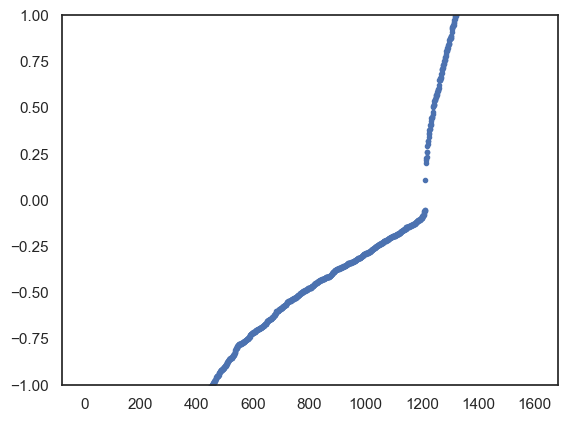

In [45]:
plt.plot(np.sort(cv_df['IL10']), '.')
plt.ylim([-1,1])

In [66]:
donor_robustness_summary[donor_robustness_summary.target_name=='FBRS']

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
316,FBRS,0.502005,0.449149,ENSG00000156860,Stim8hr,417.0,119,69,188,-16.321574,True,161.167104,False,>10 DE genes,on-target KD


In [43]:
followup_perts = ['MEN1', 'ELOB', 'ARRDC4', 'SGF29', 'GATA3', 'STAT3', 'ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'PPCS', 'NFKB2', 'FBRS']

In [44]:
cv_df.loc[followup_perts]

gene_name,IL10,IL21
target_contrast_gene_name,,
MEN1,0.214568,-0.483655
ELOB,0.259849,15.420563
ARRDC4,0.379587,-0.436202
SGF29,0.441506,2.142261
GATA3,-0.079647,3.105841
STAT3,-0.162046,7.633004
ATP2A2,8.320331,0.141325
CYB5R4,-1.446746,-0.099634
MED24,-0.250701,-0.307099


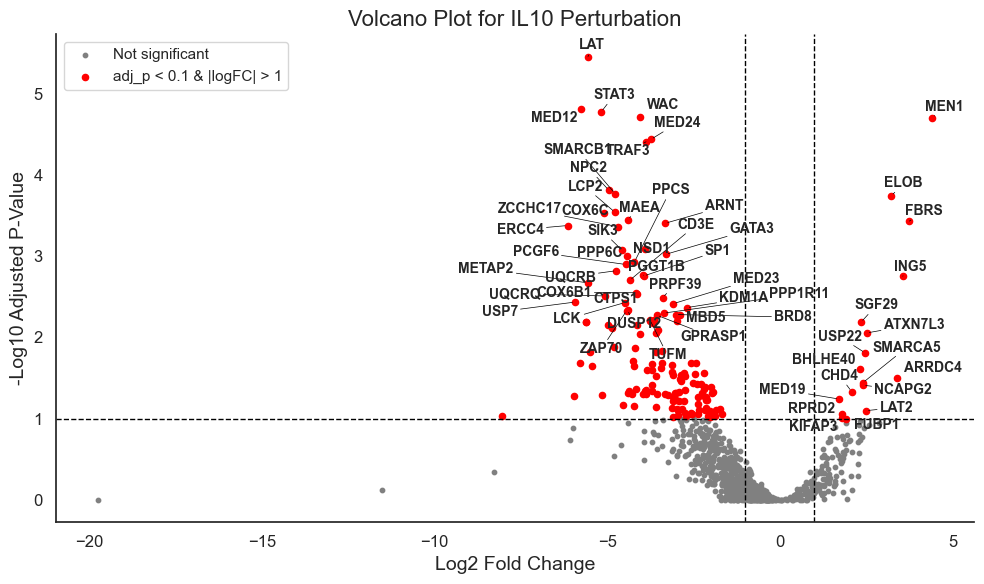

In [75]:
target_gene = 'IL10'
cv_thres = 1.5
adj_p_thres = 0.1
log_fc_thres = 1

obs_mask = (adata_de.obs.target_contrast_gene_name.isin(cv_df[cv_df[target_gene].abs()<cv_thres].index)) & (adata_de.obs.culture_condition=='Stim8hr')
var_mask = (adata_de.var.gene_name==target_gene)
log_fc = adata_de[obs_mask, var_mask].layers['log_fc'][:, 0].copy()
adj_pvals = adata_de[obs_mask, var_mask].layers['adj_p_value'][:, 0].copy()
gene_names = adata_de[obs_mask, var_mask].obs['target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Step 4: Significance mask
is_signif = (adj_pvals < adj_p_thres) & (np.abs(log_fc) > log_fc_thres)
sig_log_fc = log_fc[is_signif]
sig_pval = adj_pvals[is_signif]
sig_names = gene_names[is_signif]
sig_neglogp = neg_log10_pval[is_signif]

# Step 5: Get top N significant genes
top_n = 40
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
annot_genes = np.concatenate([left_genes, right_genes])

# Step 6: Plot
sns.set(style="white")
plt.figure(figsize=(10, 6))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif], neg_log10_pval[is_signif], c='red', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(sig_names == gene)[0][0]
    texts.append(
        plt.text(sig_log_fc[idx], sig_neglogp[idx], gene,
                 fontsize=10, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Reference lines
plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)
plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
sns.despine()
plt.tight_layout()
#plt.xlim([-8,5.5])
plt.show()

In [4]:
target_gene_list = set(de_by_guide[(de_by_guide['culture_condition']=='Stim8hr')]['target'])#&(de_by_guide['correlation']>0.3)]['target'])
target_gene_list = target_gene_list & set(donor_robustness_summary[donor_robustness_summary['donor_correlation_min']>0.3]['target_name'])
target_gene_list = list(target_gene_list)
keep = (adata_de.obs['culture_condition']=='Stim8hr')# & (adata_de.obs['target_contrast_gene_name'].isin(target_gene_list))
adata_de_filtered = adata_de[keep].to_memory()

In [5]:
adata_de_filtered[adata_de_filtered.obs.target_contrast_gene_name_corrected=='ARRDC4']

View of AnnData object with n_obs × n_vars = 1 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'masked_zscore', 'p_value', 'zscore'

In [6]:
gene1 = 'IL10'
gene2 = 'IL21'
# df_for_plot = pd.merge(get_DE_results_long(adata_de[adata_de.obs['culture_condition']=='Stim8hr'], genes=[gene1], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
#                        get_DE_results_long(adata_de[adata_de.obs['culture_condition']=='Stim8hr'], genes=[gene2], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
#                        on='target_contrast_gene_name',
#                        suffixes=['_'+gene1, '_'+gene2])
df_for_plot = pd.merge(get_DE_results_long(adata_de_filtered, genes=[gene1], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
                       get_DE_results_long(adata_de_filtered, genes=[gene2], effect_estimates=['log_fc', 'zscore'], signif_alpha=0.05),
                       on='target_contrast_gene_name',
                       suffixes=['_'+gene1, '_'+gene2])

In [10]:
donor_robustness_summary[(donor_robustness_summary['target_name'].isin(followup_perts))&(donor_robustness_summary['condition']=='Stim8hr')]

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
68,ATP2A2,0.572072,0.519132,ENSG00000174437,Stim8hr,248.0,2255,1005,3260,-15.645571,True,169.551562,False,>10 DE genes,on-target KD
209,CYB5R4,0.575195,0.527082,ENSG00000065615,Stim8hr,211.0,960,715,1675,-12.691618,True,81.444530,False,>10 DE genes,on-target KD
282,ELOB,0.569733,0.521609,ENSG00000103363,Stim8hr,1093.0,2211,841,3052,-23.532262,True,106.970248,False,>10 DE genes,on-target KD
342,GATA3,0.728725,0.660247,ENSG00000107485,Stim8hr,818.0,503,736,1239,-19.995103,True,125.439326,False,>10 DE genes,on-target KD
452,KDM1A,0.732691,0.700852,ENSG00000004487,Stim8hr,541.0,1576,725,2301,-21.050217,True,106.643849,False,>10 DE genes,on-target KD
519,MED24,0.732002,0.681347,ENSG00000008838,Stim8hr,700.0,1139,1656,2795,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
521,MEN1,0.624899,0.582537,ENSG00000133895,Stim8hr,189.0,886,430,1316,-4.519640,True,15.203544,True,>10 DE genes,on-target KD
608,NFKB2,0.377200,0.315739,ENSG00000077150,Stim8hr,2152.0,761,589,1350,-32.579928,True,242.436193,True,>10 DE genes,on-target KD
692,PPCS,0.371536,0.359377,ENSG00000127125,Stim8hr,138.0,492,300,792,-5.133298,True,26.464996,False,>10 DE genes,on-target KD
872,STAT3,0.681991,0.643249,ENSG00000168610,Stim8hr,255.0,786,584,1370,-17.634072,True,140.218986,False,>10 DE genes,on-target KD


In [22]:
followup_perts = ['MEN1', 'ELOB', 'ARRDC4', 'SGF29', 'GATA3', 'STAT3', 'ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'PPCS', 'NFKB2']
color_perts = ['#fdae6b', '#fdae6b','#fdae6b', '#fdae6b', '#9ecae1', '#9ecae1', '#fa9fb5', '#8c96c6', '#6a51a3', '#ae017e', '#ae017e', '#ae017e']

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the

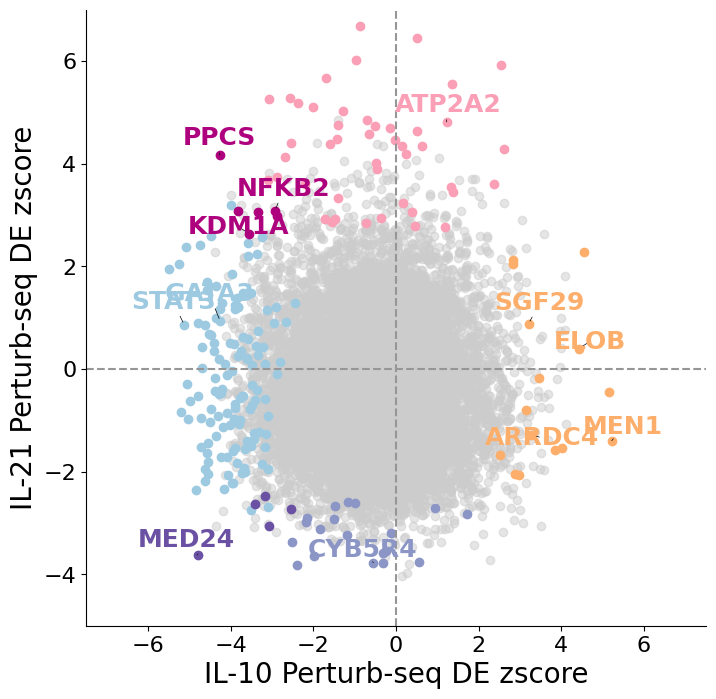

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
# Non-significance
mask = ~df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#cccccc', alpha=0.5)
# Gene1 significant with zscore>0
mask = df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#fdae6b')
# Gene1 significant with zscore<0
mask = df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#9ecae1')
# Gene2 significant with zscore>0
mask = ~df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2] &(df_for_plot['zscore_'+gene2]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#fa9fb5')
# Gene2 significant with zscore<0
mask = ~df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2] &(df_for_plot['zscore_'+gene2]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#8c96c6')
# Both significant with zscore both <0
mask = df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)&(df_for_plot['zscore_'+gene2]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#6a51a3')
# Both significant with gene1 zscore<0 gene2 zscore>0
mask = df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)&(df_for_plot['zscore_'+gene2]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#ae017e')
ax.set_xlim([-7.5,7.5])
ax.set_ylim([-5,7])
ax.tick_params(labelsize=16)
ax.set_xlabel('IL-10 Perturb-seq DE zscore', fontsize=20)
ax.set_ylabel('IL-21 Perturb-seq DE zscore', fontsize=20)

# Labels
texts = []
for ind, pert in enumerate(followup_perts):
    texts.append(
        ax.text(df_for_plot.loc[df_for_plot['target_contrast_gene_name']==pert, 'zscore_'+gene1], df_for_plot.loc[df_for_plot['target_contrast_gene_name']==pert, 'zscore_'+gene2], pert,
                 fontsize=18, weight='bold', ha='center', va='bottom', color=color_perts[ind])
    )

# for _, row in df_for_plot[mask].iterrows():
#     texts.append(
#         plt.text(row['zscore_'+gene1], row['zscore_'+gene2], row['target_contrast_gene_name'],
#                  fontsize=10, weight='bold', ha='center', va='bottom')
#     )

# Adjust to avoid collisions
adjust_text(texts, x=df_for_plot['zscore_'+gene1], y=df_for_plot['zscore_'+gene2], arrowprops=dict(arrowstyle="-", color='black', lw=0.5), force_static=(0.5,0.5))

plt.axhline(0, linestyle='--', color='#969696')
plt.axvline(0, linestyle='--', color='#969696')

sns.despine()

#plt.savefig('./results/IL10IL21_selected_regulators.png')

In [28]:
followup_perts = ['MEN1', 'ELOB', 'SGF29', 'GATA3', 'STAT3', 'ATP2A2', 'CYB5R4', 'MED24', 'KDM1A', 'NFKB2', 'PPCS']#, 'ARRDC4']
color_perts = ['#fdae6b', '#fdae6b','#fdae6b', '#9ecae1', '#9ecae1', '#fa9fb5', '#8c96c6', '#6a51a3', '#ae017e', '#ae017e', '#ae017e', '#a1d99b']

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the

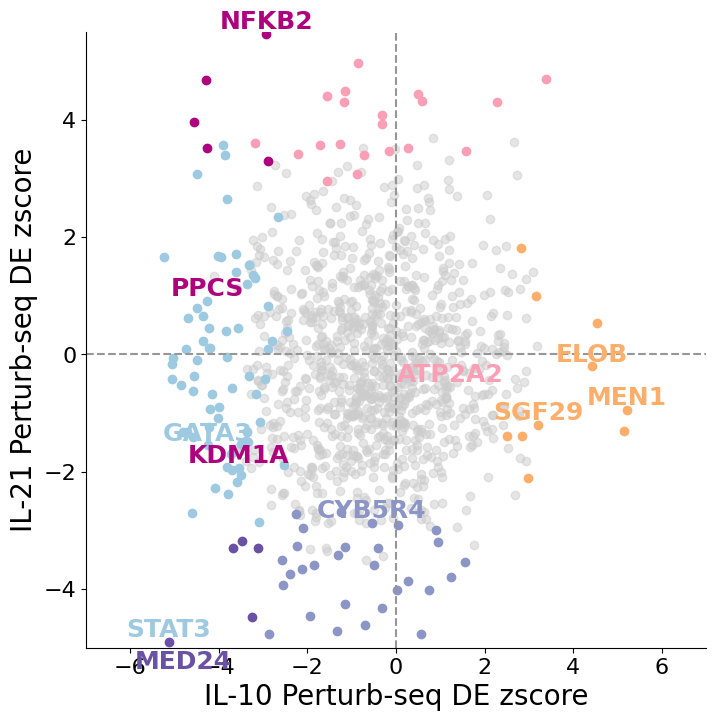

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
# Non-significance
mask = ~df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#cccccc', alpha=0.5)
# Gene1 significant with zscore>0
mask = df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#fdae6b')
# Gene1 significant with zscore<0
mask = df_for_plot['significant_'+gene1]&~df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#9ecae1')
# Gene2 significant with zscore>0
mask = ~df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2] &(df_for_plot['zscore_'+gene2]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#fa9fb5')
# Gene2 significant with zscore<0
mask = ~df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2] &(df_for_plot['zscore_'+gene2]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#8c96c6')
# Both significant with zscore both <0
mask = df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)&(df_for_plot['zscore_'+gene2]<0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#6a51a3')
# Both significant with gene1 zscore<0 gene2 zscore>0
mask = df_for_plot['significant_'+gene1]&df_for_plot['significant_'+gene2]&(df_for_plot['zscore_'+gene1]<0)&(df_for_plot['zscore_'+gene2]>0)
ax.scatter(df_for_plot[mask]['zscore_'+gene1], df_for_plot[mask]['zscore_'+gene2], c='#ae017e')
ax.set_xlim([-7,7])
ax.set_ylim([-5,5.5])
ax.tick_params(labelsize=16)
ax.set_xlabel('IL-10 Perturb-seq DE zscore', fontsize=20)
ax.set_ylabel('IL-21 Perturb-seq DE zscore', fontsize=20)

# Labels
texts = []
for ind, pert in enumerate(followup_perts):
    texts.append(
        ax.text(df_for_plot.loc[df_for_plot['target_contrast_gene_name']==pert, 'zscore_'+gene1], df_for_plot.loc[df_for_plot['target_contrast_gene_name']==pert, 'zscore_'+gene2], pert,
                 fontsize=18, weight='bold', ha='center', va='bottom', color=color_perts[ind])
    )

# for _, row in df_for_plot[mask].iterrows():
#     texts.append(
#         plt.text(row['zscore_'+gene1], row['zscore_'+gene2], row['target_contrast_gene_name'],
#                  fontsize=10, weight='bold', ha='center', va='bottom')
#     )

# Adjust to avoid collisions
#adjust_text(texts, x=df_for_plot['zscore_'+gene1], y=df_for_plot['zscore_'+gene2], arrowprops=dict(arrowstyle="-", color='black', lw=0.5), force_static=(0.5,0.5))

plt.axhline(0, linestyle='--', color='#969696')
plt.axvline(0, linestyle='--', color='#969696')

sns.despine()

In [27]:
adata_de_filtered[adata_de_filtered.obs.target_contrast_gene_name_corrected=='ARRDC4',
    adata_de_filtered.var.gene_name=='IFNG'].layers['zscore']

ArrayView([[-3.50622616]])

In [ ]:
adata_de_filtered[adata_de_filtered.obs.target_contrast_gene_name_corrected=='ARRDC4',
    adata_de_filtered.var.gene_name=='IFNG'].layers['zscore']

In [428]:
validation_df

,Sample:,Donor,sgRNA,IL10_fc,IL21_fc,IL10_lfc,IL21_lfc,p_value_IL10,p_value_IL21
0,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_B...,Donor 3,GATA3,0.274306,0.560396,-1.866144,-0.835481,0.013342,0.620835
1,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_B...,Donor 3,MEN1,2.805556,0.288119,1.488286,-1.795264,0.004771,0.313105
2,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_C...,Donor 3,CYB5R4,0.555556,0.118812,-0.847997,-3.073249,0.013373,0.009111
3,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_C...,Donor 3,ELOB,3.854167,1.148515,1.946419,0.199770,0.009371,0.146435
4,Diff060Day9Mix_09292025_Experiment_Day9Th2D1_C...,Donor 3,ATP2A2,0.892361,1.861386,-0.164300,0.896377,0.074924,0.024905
5,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_D...,Donor 4,GATA3,0.376518,1.946154,-1.409208,0.960626,0.013342,0.620835
6,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_D...,Donor 4,MEN1,3.748988,1.792308,1.906501,0.841818,0.004771,0.313105
7,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_E...,Donor 4,CYB5R4,0.570850,0.294872,-0.808816,-1.761840,0.013373,0.009111
8,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_E...,Donor 4,ELOB,2.028340,1.343590,1.020300,0.426093,0.009371,0.146435
9,Diff060Day9Mix_09292025_Experiment_Day9Th2D2_E...,Donor 4,ATP2A2,0.603239,3.641026,-0.729199,1.864345,0.074924,0.024905


/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1960/1272591120.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(validation_df, y='sgRNA', x='IL10_lfc', ax=ax[0], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])
/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_1960/1272591120.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(validation_df, y='sgRNA', x='IL21_lfc', ax=ax[1], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])


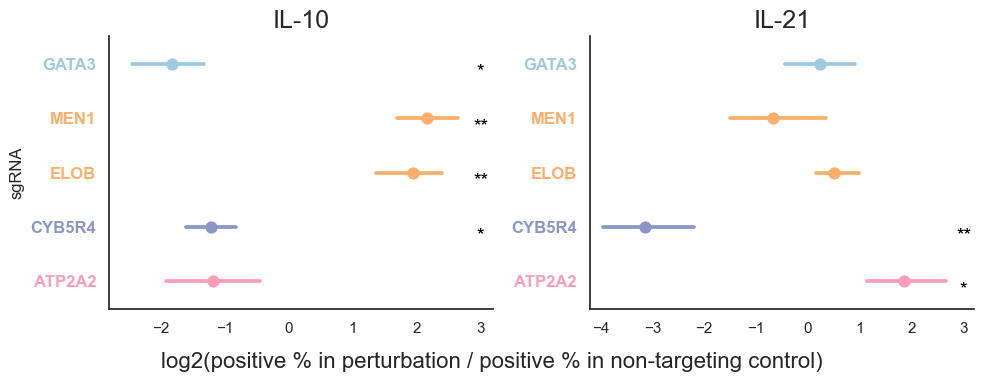

In [446]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
sns.pointplot(validation_df, y='sgRNA', x='IL10_lfc', ax=ax[0], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])

y_coords = [0,1,2,3,4]
x_coords = pd.DataFrame(validation_df.groupby('sgRNA')['IL10_lfc'].mean()).loc[['GATA3','MEN1','ELOB','CYB5R4','ATP2A2']].values[:,0]

for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    sg = ['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'][i]
    p = validation_df.loc[validation_df['sgRNA'] == sg, 'p_value_IL10'].values[0]
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    else:
        star = ''
    if star:
        ax[0].text(3, y, star, ha='center', va='top', fontsize=14, color='black')

sns.pointplot(validation_df, y='sgRNA', x='IL21_lfc', ax=ax[1], order=['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'], palette=['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5'])

y_coords = [0,1,2,3,4]
x_coords = pd.DataFrame(validation_df.groupby('sgRNA')['IL21_lfc'].mean()).loc[['GATA3','MEN1','ELOB','CYB5R4','ATP2A2']].values[:,0]

for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    sg = ['GATA3','MEN1','ELOB','CYB5R4','ATP2A2'][i]
    p = validation_df.loc[validation_df['sgRNA'] == sg, 'p_value_IL21'].values[0]
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    else:
        star = ''
    if star:
        ax[1].text(3, y, star, ha='center', va='top', fontsize=14, color='black')

tick_colors = ['#9ecae1', '#fdae6b', '#fdae6b', '#8c96c6', '#fa9fb5']
for i, tick_label in enumerate(ax[0].get_yticklabels()):
    tick_label.set_color(tick_colors[i])
    tick_label.set_fontweight('bold')
    tick_label.set_fontsize(12)

for i, tick_label in enumerate(ax[1].get_yticklabels()):
    tick_label.set_color(tick_colors[i])
    tick_label.set_fontweight('bold')
    tick_label.set_fontsize(12)

# ax[0].set_xlabel('Perturbation')
# ax[0].set_ylabel(r'logFoldChange(IL10+$^{perturbation}$/IL10+^{control})')

ax[0].set_title('IL-10', fontsize=18)
ax[1].set_title('IL-21', fontsize=18)
ax[0].set_xlim([-2.8,3.2])
ax[1].set_xlim([-4.2,3.2])
ax[1].set_ylabel('')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
fig.supxlabel('log2(positive % in perturbation / positive % in non-targeting control)',fontsize=16,y=0.05)

sns.despine()
plt.tight_layout()
plt.savefig('./results/IL10IL21_validation.png')

<Axes: xlabel='sgRNA', ylabel='IL21_lfc'>

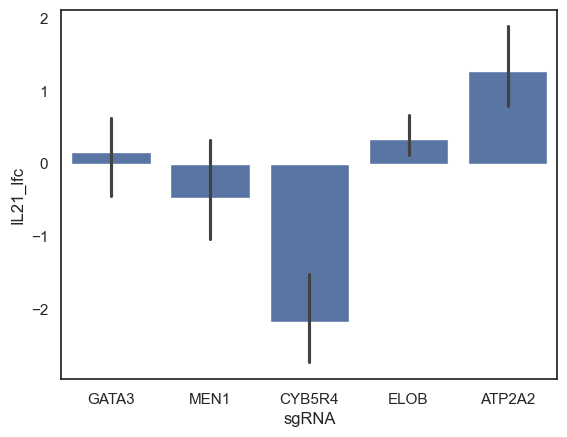

In [239]:
sns.barplot(validation_df, x='sgRNA', y='IL21_lfc')

In [3]:
de_donor_robustness.layers['zscore'] = de_donor_robustness.layers['log_fc'] / de_donor_robustness.layers['lfcSE']
de_donor_robustness.layers['zscore'][np.where(de_donor_robustness.layers['zscore'] > 50)] = 50
de_donor_robustness.X = np.nan_to_num(de_donor_robustness.layers['zscore'], 0)

In [12]:
de_donor_robustness = de_donor_robustness[de_donor_robustness.obs.culture_condition=='Stim8hr'].copy()

In [13]:
reg_all = ['MEN1', 'ELOB', 'FBRS', 'SGF29', 'ATP2A2', 'MED24', 'GATA3', 'CYB5R4', 'STAT3', 'APC', 'NFKB2', 'ATXN7L3', 'ELP2', 'PPCS', 'CCNC']
gene = ['IL22']

In [14]:
donor_pairs = de_donor_robustness.obs['donor_pair'].unique()

In [15]:
df_reg_gene = pd.DataFrame()
for donor_pair in donor_pairs:
    temp_df = get_DE_results_long(de_donor_robustness[de_donor_robustness.obs['donor_pair']==donor_pair], targets=de_donor_robustness.obs['target_contrast_gene_name'].tolist(), genes = gene)
    temp_df['donor_pair'] = donor_pair
    df_reg_gene = pd.concat([df_reg_gene, temp_df])
df_reg_gene = df_reg_gene.reset_index(drop=True)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_66609/1968415089.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plt.plot(np.sort(df_reg_gene.groupby('target_contrast_gene_name')['zscore'].std()/df_reg_gene.groupby('target_contrast_gene_name')['zscore'].mean()), '.')


(-10.0, 10.0)

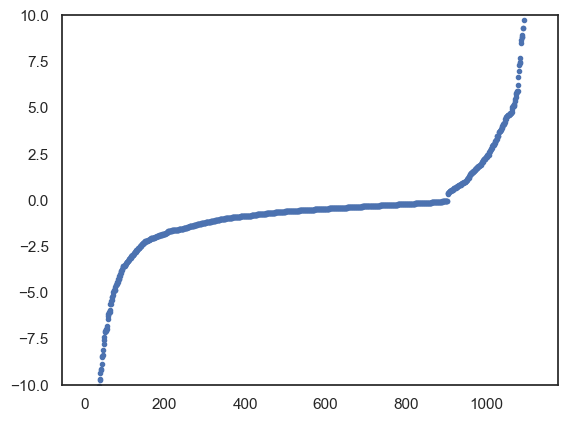

In [16]:
plt.plot(np.sort(df_reg_gene.groupby('target_contrast_gene_name')['zscore'].std()/df_reg_gene.groupby('target_contrast_gene_name')['zscore'].mean()), '.')
plt.ylim([-10,10])

### Set coefficient of variation < 1

In [24]:
reg = 'HNRNPA2B1'
df_reg_gene[df_reg_gene['target_contrast_gene_name']==reg].zscore.std()/df_reg_gene[df_reg_gene['target_contrast_gene_name']==reg].zscore.mean()

1.7479350214951164

In [451]:
target_gene_list = set(de_by_guide[(de_by_guide['culture_condition']=='Stim8hr')&(de_by_guide['correlation']>0.3)]['target'])
target_gene_list = target_gene_list & set(donor_robustness_summary[donor_robustness_summary['donor_correlation_min']>0.3]['target_name'])
target_gene_list = list(target_gene_list)

In [452]:
keep = (adata_de.obs['culture_condition']=='Stim8hr') & (adata_de.obs['target_contrast_gene_name'].isin(target_gene_list))
adata_de_filtered = adata_de[keep].to_memory()
#adata_de_filtered = adata_de.to_memory()

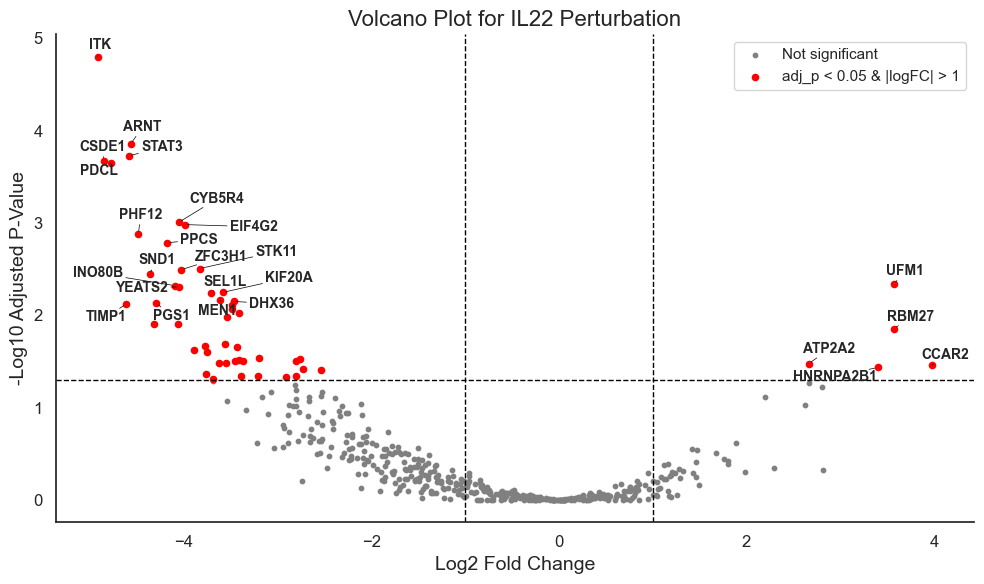

In [454]:
target_gene = 'IL22'
adj_p_thres = 0.05
log_fc_thres = 1

target_idx = np.where(adata_de_filtered.var['gene_name'] == target_gene)[0][0]
log_fc = adata_de_filtered[:, target_idx].layers['zscore'][:, 0]
adj_pvals = adata_de_filtered[:, target_idx].layers['adj_p_value'][:, 0]

log_fc = log_fc.toarray().flatten()
adj_pvals = adj_pvals.toarray().flatten()
gene_names = adata_de_filtered.obs.loc[:, 'target_contrast_gene_name_corrected'].values
neg_log10_pval = -np.log10(np.clip(adj_pvals, 1e-300, 1))

# Step 4: Significance mask
is_signif = (adj_pvals < adj_p_thres) & (np.abs(log_fc) > log_fc_thres)
sig_log_fc = log_fc[is_signif]
sig_pval = adj_pvals[is_signif]
sig_names = gene_names[is_signif]
sig_neglogp = neg_log10_pval[is_signif]

# Step 5: Get top N significant genes
top_n = 20
left_mask = sig_log_fc < 0
left_idx = np.argsort(-sig_neglogp[left_mask])[:top_n]
left_genes = sig_names[left_mask][left_idx]
right_mask = sig_log_fc > 0
right_idx = np.argsort(-sig_neglogp[right_mask])[:top_n]
right_genes = sig_names[right_mask][right_idx]
annot_genes = np.concatenate([left_genes, right_genes])

# Step 6: Plot
sns.set(style="white")
plt.figure(figsize=(10, 6))
plt.scatter(log_fc, neg_log10_pval, c='grey', s=10, label='Not significant')
plt.scatter(log_fc[is_signif], neg_log10_pval[is_signif], c='red', s=20, label=f'adj_p < {adj_p_thres} & |logFC| > {log_fc_thres}')

# Labels
texts = []
for gene in annot_genes:
    idx = np.where(sig_names == gene)[0][0]
    texts.append(
        plt.text(sig_log_fc[idx], sig_neglogp[idx], gene,
                 fontsize=10, weight='bold', ha='center', va='bottom')
    )

# Adjust to avoid collisions
adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

# Reference lines
plt.axvline(-log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axvline(log_fc_thres, color='black', linestyle='--', linewidth=1)
plt.axhline(-np.log10(adj_p_thres), color='black', linestyle='--', linewidth=1)

# Labels and formatting
plt.xlabel('Log2 Fold Change', fontsize=14)
plt.ylabel('-Log10 Adjusted P-Value', fontsize=14)
plt.title(f'Volcano Plot for {target_gene} Perturbation', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [28]:
annot_genes = ['MEN1', 'ELOB', 'FBRS', 'SGF29', 'ATP2A2', 'MED24', 'GATA3', 'CYB5R4', 'STAT3'] # 'ATXN7L3', 'ELP2', 'PPCS']

In [92]:
summary_df.loc[['TBX21','GATA3','CFAP298','SORL1','PTPN2','POLE3','MEN1',
                'ARRDC4','CYB5R4','SFXN1','ELOB','ZNF74','ATP2A2','CCNC','TMED9'], 'IFNG_flowlfc'] = np.log([0.236682951,1.115685095,0.707111303,
                                                                                                             0.808116441,1.340527288,1.066418252,
                                                                                                             1.625631301,1.35879521,0.330350345,
                                                                                                             0.829940691,1.253849169,0.877373787,
                                                                                                             1.049694857,1.373313557,1.652605838])

In [93]:
annotations = summary_df[['zscore_IFNG', 'IFNG_flowlfc']].astype(str)
for i in range(len(df)):
    if summary_df['padj_IFNG'].iloc[i] < 0.05:
        annotations.iloc[i, 0] = f"{summary_df['padj_IFNG'].iloc[i]:.2e}"
        annotations.iloc[i, 1] = f""
    else:
        annotations.iloc[i, 0] = f""
        annotations.iloc[i, 1] = f""

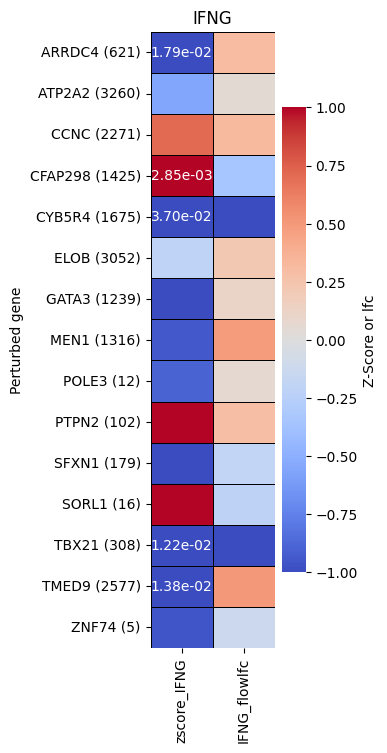

In [95]:
# Plot the heatmap
plt.figure(figsize=(2, 8))
sns.heatmap(
    summary_df[['zscore_IFNG', 'IFNG_flowlfc']],
    annot=annotations,
    fmt="",
    cmap='coolwarm',
    cbar_kws={'label': 'Z-Score or lfc'},
    linewidths=0.5,
    linecolor='black',
    yticklabels=[gene+f' ({nde})' for gene, nde in zip(summary_df.index,summary_df.n_total_de_genes)],
    vmin=-1,
    vmax=1
)
plt.title('IFNG')
plt.ylabel('Perturbed gene')
plt.yticks(rotation=0)
plt.show()

### Pick state regulators

In [40]:
polarization_coefficient = pd.read_csv('../4_polarization_signatures/results/polarization_prediction_condition_comparison.regulator_coefficients.csv', index_col=0)

In [41]:
test = polarization_coefficient[(polarization_coefficient['signature']=='ota')&(polarization_coefficient['celltype']=='Stim8hr')].copy()

In [42]:
test = test.drop(columns=['dataset_key', 'celltype', 'signature'])

In [43]:
test['Th2_Rank'] = test['coef_mean'].rank()
test['Th1_Rank'] = test['coef_mean'].rank(ascending=False)

In [44]:
test = pd.merge(test, de_by_guide[de_by_guide.culture_condition=='Stim8hr'][de_by_guide.columns[[0,1,2]]], how='outer', left_on='regulator', right_on='target')
test = pd.merge(test, donor_robustness_summary[donor_robustness_summary.columns[[0,1,2,5,8,9,11]]], how='outer', left_on='regulator', right_on='target_name')

In [45]:
genelist = ['CFAP298', 'SORL1', 'PTPN2', 'BCL9', 'POLE3', 'MEN1', 'ARRDC4', 'CYB5R4', 'SFXN1', 'ELOB', 'ZNF74', 'ATP2A2',
            'CCNC', 'TMED9', 'GATA3', 'TBX21', 'PTPRC', 'RPTOR', 'WAS', 'MBD2', 'FBRS', 'MEAF6', 'LAT2', 'MTA2', 'CLCC1', 
            'UBE2E2', 'MED24', 'SGF29', 'STAT3', 'NFKB2', 'PPCS', 'KDM1A', 'EHMT2', 'SEC22A', 'PSMF1', 'NAB2', 'RELL2', 'PCNX3',
            'JAK2']

In [46]:
test[test.regulator.isin(genelist)]

,coef_mean,coef_sem,coef_rank,regulator,known_regulators,regulator_type,Th2_Rank,Th1_Rank,target,correlation,correlation_ceiling,target_name,donor_correlation_mean,donor_correlation_min,n_cells_target,n_total_de_genes,ontarget_effect_size,baseMean
212,-0.002648,0.000848,0.631177,ARRDC4,False,NaN,1449.0,2479.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,0.002699,0.000770,0.409322,ATP2A2,False,NaN,2320.0,1608.0,ATP2A2,0.649677,0.844653,ATP2A2,0.572072,0.519132,248.0,3260.0,-15.645571,169.551562
311,0.015013,0.000759,0.064442,BCL9,False,NaN,3674.0,254.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493,-0.002563,0.000942,0.627866,CCNC,False,NaN,1462.0,2466.0,CCNC,0.260627,NaN,CCNC,0.324906,0.198766,3668.0,2271.0,-41.369513,129.001289
582,-0.013256,0.000621,0.919002,CFAP298,False,NaN,319.0,3609.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
621,-0.019181,0.000672,0.975038,CLCC1,False,NaN,99.0,3829.0,CLCC1,0.791215,0.836926,CLCC1,0.402019,0.287878,1040.0,680.0,-16.635372,32.907657
769,0.003210,0.000866,0.389455,CYB5R4,False,NaN,2398.0,1530.0,CYB5R4,0.749643,0.882319,CYB5R4,0.575195,0.527082,211.0,1675.0,-12.691618,81.444530
958,0.026561,0.001444,0.004330,EHMT2,False,NaN,3910.0,18.0,EHMT2,0.853201,0.904109,EHMT2,0.776014,0.756458,593.0,1178.0,-21.517053,95.876564
991,0.004066,0.001273,0.355323,ELOB,False,NaN,2532.0,1396.0,ELOB,0.411224,NaN,ELOB,0.569733,0.521609,1093.0,3052.0,-23.532262,106.970248
1126,0.006389,0.000778,0.265410,FBRS,False,NaN,2885.0,1043.0,FBRS,0.260291,0.877058,FBRS,0.502005,0.449149,417.0,188.0,-16.321574,161.167104


In [16]:
test

,coef_mean,coef_sem,coef_rank,regulator,known_regulators,dataset_key,regulator_type,celltype,signature,target,correlation,correlation_ceiling,target_name,donor_correlation_mean,donor_correlation_min,n_cells_target,n_total_de_genes,ontarget_effect_size,baseMean,Rank
0,-0.004506,0.000778,0.705298,A2M,False,ota_Stim8hr,NaN,Stim8hr,ota,A2M,0.087182,0.495089,A2M,0.170529,-0.002503,292.0,164.0,0.000000,NaN,1158.0
1,0.005085,0.000654,0.315079,AACS,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2690.0
2,0.005064,0.001117,0.316607,AAGAB,False,ota_Stim8hr,NaN,Stim8hr,ota,AAGAB,0.846621,0.979353,AAGAB,0.857296,0.814893,535.0,34.0,-19.262203,85.633443,2684.0
3,0.001785,0.000746,0.457208,AAMDC,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2132.0
4,0.010547,0.000744,0.141365,AAR2,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3372.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3922,-0.004985,0.000420,0.719817,ZSCAN32,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1101.0
3923,-0.011497,0.000435,0.892002,ZSWIM4,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,425.0
3924,-0.005491,0.000956,0.742741,ZSWIM9,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011.0
3925,0.008574,0.000526,0.195619,ZW10,False,ota_Stim8hr,NaN,Stim8hr,ota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3159.0


In [30]:
de_by_guide[de_by_guide.target=='FBXO32']

,target,correlation,correlation_ceiling,n_signif,culture_condition


In [31]:
de_by_guide

,target,correlation,correlation_ceiling,n_signif,culture_condition
0,A2M,-0.466086,NaN,10,Rest
1,ABCC1,0.084480,NaN,84,Rest
2,ABHD12,0.490760,0.628502,360,Rest
3,ABHD13,-0.301527,0.527995,507,Rest
4,ABHD14A,0.958795,0.943289,5,Rest
...,...,...,...,...,...
3047,ZNF76,0.517532,0.923784,25,Stim48hr
3048,ZNF829,0.628259,0.886746,52,Stim48hr
3049,ZNF837,0.565384,0.863103,83,Stim48hr
3050,ZNF92,0.053507,0.518101,124,Stim48hr
